In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Introduction

How might an agent learn the value of a single stimulus, given computational constraints like memory capacity?

Based on [Bob Wilson's](http://u.arizona.edu/~bob/web_NSCS344/index.html) computational modeling class.

## 1.1 Modeling the slot machine

First, let's simulate a slot machine. In the RL literature, this is commonly known as a **`one-armed bandit`**, so named because a slot machine has a single lever (arm) that robs people of their money (bandit).

As slot machines go, this one is pretty boring. You pull the lever, and then it tells you whether you won or not.

The function is a thin wrapper around the binomial function, with a more descriptive name.

In [2]:
def play_slot_machine(p_winning, n_plays):
    return np.random.binomial(n = 1, p = p_winning, size = n_plays)

In [3]:
play_slot_machine(p_winning = 0.4, n_plays = 10)

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1])

# 2.0 Learning models

## 2.1 Running average model

First, let's write a learning model that just takes the **`running average`**. This is conceptually simple, and if we want to form an expectation for the (long-term) **`value`** of the slot machine, it's hard to beat the mean.

$ V_{t} = \frac{1}{t} \sum_{i=1}^{t} r_{i} $

In [4]:
def learn_run_avg(rewards):
    history_value_est = np.zeros(len(rewards))
    for current_trial in np.arange(len(rewards)):
        if current_trial == 0:
            current_value_est = rewards[0]
        else:
            current_value_est = rewards[0:current_trial+1].mean()
        history_value_est[current_trial] = current_value_est
    return history_value_est

Now we'll simulate many more trials from that slot machine and compute running averages.

In [5]:
est_value = pd.DataFrame(
    {
        'trial': np.arange(100),
        'reward': play_slot_machine(p_winning = 0.4, n_plays = 100),
    }
)

In [6]:
est_value['est_run_avg'] = learn_run_avg(est_value.reward)

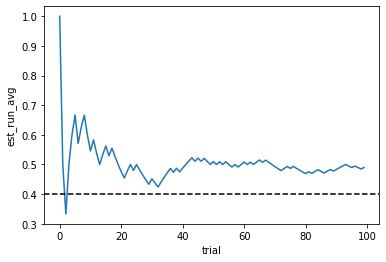

In [7]:
plot_run_avg = sns.lineplot(
    x = 'trial',
    y = 'est_run_avg',
    data = est_value
)
plot_run_avg.axhline(y=0.4, c='black', linestyle='dashed')
plot_run_avg

## 2.2 Temporal difference model

So it seems like the running average model does pretty good. But is it psychologically plausible? Not really. If you're taking the running average, you have to represent *all* of the rewards you've *ever* gotten in order to calculate the average. So as time goes on, the computational demands grow and grow.

We'd like to find an alternative formulation that allows us to keep the computational demands constant across time. How could we do this? Intuitively, we could say that we're only interested in *updating* our value estimate relative to our most recent expectation. In other words, we make a **`prediction`** about the **`reward`** we'll get next, observe what we reward we actually get, and then use that **`reward prediction error`** as the basis for updating our value estimate. This is known as a **`temporal difference`** method because the prediction error is computed as the reward-value difference at two (successive) points in time.

Let's start with the equation for taking a running average:  
$ V_{t} = \frac{1}{t} \sum_{i=1}^{t} r_{i} $

Let's explicitly expand out the sum of that:  
$ V_{t} = \frac{1}{t} (r_{1} + r_{2} + ... + r_{t-1} + r_{t}) $

Now, let's rewind one trial back and rewrite that summation:  
$ V_{t-1} = \frac{1}{t-1} (r_{1} + r_{2} + ... + r_{t-2} + r_{t-1}) $  

Which can be algebraically written to isolate the rewards:  
$ (V_{t-1})(t-1) = (r_{1} + r_{2} + ... + r_{t-2} + r_{t-1}) $  

Now, we can replace almost everything in the first summation:  
$ V_{t} = \frac{1}{t} [(V_{t-1})(t-1) + r_{t}] $

We do a little bit of algebra to expand the term $ (V_{t-1})(t-1) $:  
$ V_{t} = \frac{1}{t} [(V_{t-1})(t)-(V_{t-1}) + r_{t}] $

And now we do just a little more algebra to get this equation into a form where we're using the prediction error (reward observed minus expected value) to drive learning:  
$ V_{t} = V_{t-1} + \frac{1}{t} (r_{t}-V_{t-1}) $

The really nice thing about this form is that it only requires an agent to maintain three pieces of information: how many trials have occurred (number of times we've played the slot machine), the expected value of the slot machine, and the presently-observed reward from the slot machine. So the computational demands stay constant over time.

In [8]:
def learn_td(rewards):
    history_value_est = np.zeros(len(rewards))
    for current_trial in np.arange(0, len(rewards)):
        if current_trial == 0:
            current_value_est = rewards[current_trial]
        else:
            current_value_est = current_value_est + (1/(current_trial+1)) * (rewards[current_trial]-current_value_est)
        history_value_est[current_trial] = current_value_est
    return history_value_est

In [9]:
est_value['est_td'] = learn_td(est_value.reward)

So how does the temporal difference model compare against the running average model from before? Below, we plot both models' predictions. We can see that they are identical. This is pretty sensical given that the TD formulation is just an algebraic rewriting of the running average.

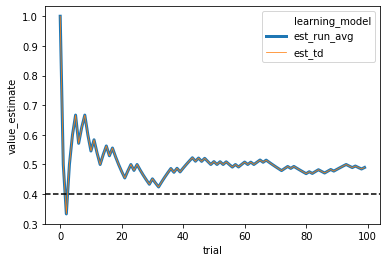

In [10]:
plot_learning = sns.lineplot(
    x='trial',
    y='value_estimate',
    hue='learning_model',
    size='learning_model',
    data=pd.melt(
        frame=est_value,
        id_vars=['trial', 'reward'],
        var_name='learning_model',
        value_name='value_estimate'
        )
)
plot_learning.axhline(y=0.4, c='black', linestyle='dashed')
plot_learning

# 3.0 Changepoints

## 3.1 The problem of averaging

So it's great that we have such a simple yet powerful model for estimating value from rewards. But unfortunately, there's a major problem with this model. In the real world, the expected value of a given stimulus could change. A collaborator starts experiencing academic burnout, and suddenly becomes less productive. A new government regulation forces casinos to change the minimum probability of winning a slot machine play. And so on. What does our temporal difference model do when confronted with a dramatic changepoint?

In [11]:
est_changepoint = pd.DataFrame(
    {
        'trial': np.arange(0, 200),
        'reward': np.append(
            play_slot_machine(p_winning=0.95, n_plays=100),
            play_slot_machine(p_winning=0.05, n_plays=100)
            ),
        'p_winning': np.append(np.repeat(0.95, 100), np.repeat(0.05, 100))
        }
    )

est_changepoint['est_td'] = learn_td(est_changepoint.reward)

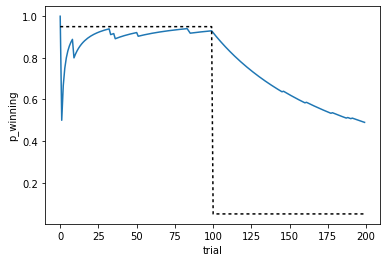

In [12]:
plot_changepoint = sns.lineplot(
    x='trial',
    y='est_td',
    data=est_changepoint
)
plot_changepoint = sns.lineplot(
    x='trial',
    y='p_winning',
    color='black',
    style=True,
    dashes=[(2, 2)],
    legend=False,
    data=est_changepoint
)
plot_changepoint

So we can see that when there's a changepoint (even when it's this dramatic!), the standard TD model has a hard time keeping up. It has a long history learning the average prior to the changepoint, and the $\frac{1}{t}$ weighting term gets smaller as $t$ gets larger.

This term is known as the **`learning rate`**. In the standard model, the learning rate gets smaller and smaller as time goes on. One simple change would be to alter the learning rate so that it stays constant over time. We'll represent that constant learning rate as $\alpha\$.

## 3.2 Fixed learning rate

So this model simply replaces $\frac{1}{t}$ with some fixed $\alpha$ ranging from 0-1.

In [13]:
def learn_fixed_alpha(rewards, alpha):
    history_value_est = np.zeros(len(rewards))
    for current_trial in np.arange(0, len(rewards)):
        if current_trial == 0:
            current_value_est = alpha * rewards[current_trial]
        else:
            current_value_est = current_value_est + alpha * (rewards[current_trial]-current_value_est)
        history_value_est[current_trial] = current_value_est
    return history_value_est

In [14]:
est_changepoint['est_fixed_alpha'] = learn_fixed_alpha(rewards=est_changepoint.reward, alpha=0.2)

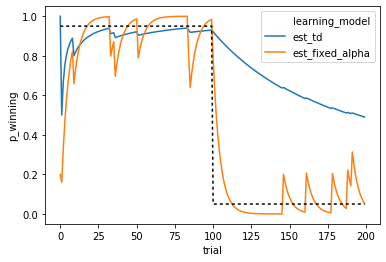

In [15]:
plot_changepoint_alpha = sns.lineplot(
    x='trial',
    y='value_estimate',
    hue='learning_model',
    data=pd.melt(
        frame=est_changepoint,
        id_vars=['trial', 'reward', 'p_winning'],
        var_name='learning_model',
        value_name='value_estimate'
        )
)
plot_changepoint_alpha = sns.lineplot(
    x='trial',
    y='p_winning',
    color='black',
    style=True,
    dashes=[(2, 2)],
    legend=False,
    data=est_changepoint
)
plot_changepoint_alpha

So we see that with $\alpha=0.2$, the model is pretty good at adjusting to the changepoint. However, it comes at a cost: the value estimates are more sensitive and don't converge as smoothly on the "true" value of the stimulus.

Let's try one thing more: computing and plotting the learning model predictions when $\alpha$ is set to 0.01, 0.1, and 0.5.

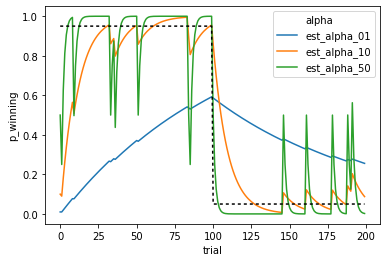

In [16]:
est_changepoint['est_alpha_01'] = learn_fixed_alpha(rewards=est_changepoint.reward, alpha=0.01)
est_changepoint['est_alpha_10'] = learn_fixed_alpha(rewards=est_changepoint.reward, alpha=0.10)
est_changepoint['est_alpha_50'] = learn_fixed_alpha(rewards=est_changepoint.reward, alpha=0.50)

plot_compare_alpha = sns.lineplot(
    x='trial',
    y='value_estimate',
    hue='alpha',
    data=pd.melt(
        frame=est_changepoint.filter(items=['trial', 'reward', 'p_winning', 'est_alpha_01', 'est_alpha_10', 'est_alpha_50']),
        id_vars=['trial', 'reward', 'p_winning'],
        var_name='alpha',
        value_name='value_estimate'
        )
)
plot_compare_alpha = sns.lineplot(
    x='trial',
    y='p_winning',
    color='black',
    style=True,
    dashes=[(2, 2)],
    legend=False,
    data=est_changepoint
)
plot_compare_alpha

So we see that as alpha increases, the agent is faster at updating its value estimate. This is good for detecting changepoints, but also makes the agent's value estimate more volatile.